In [1]:
#load the Basic libraries
import pandas as pd
import numpy as np
import pandas_profiling as pp
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load visualization libraries
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.graphics.tsaplots as tsa_plots
from matplotlib.patches import Rectangle
%matplotlib inline

In [3]:
# Load Time series Libraries
import itertools
import statsmodels.formula.api as smf 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [4]:
raw_data=pd.read_excel('Airlines+Data.xlsx')
raw_data.head() 

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [5]:
raw_data.tail() 

,Month,Passengers
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271
95,2002-12-01,306


In [6]:
data = raw_data.copy()

In [7]:
data.info() #No Null values
#Note data type of data columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [8]:
data.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


##### Visualizing the data

In [9]:
viz=pd.read_excel('Airlines+Data.xlsx',
                  header=0,index_col=0,parse_dates=True,squeeze=True)
viz

Month
1995-01-01    112
1995-02-01    118
1995-03-01    132
1995-04-01    129
1995-05-01    121
             ... 
2002-08-01    405
2002-09-01    355
2002-10-01    306
2002-11-01    271
2002-12-01    306
Name: Passengers, Length: 96, dtype: int64

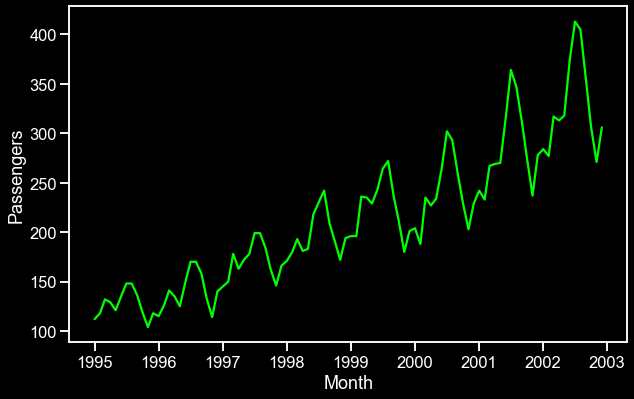

In [10]:
#Line plot
sns.set(rc={'figure.figsize':(10,6.18)})
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
sns.lineplot(data=viz, color='lime')
plt.show()
#There seems to be a quadratic upward tend with multiplicative seasonality

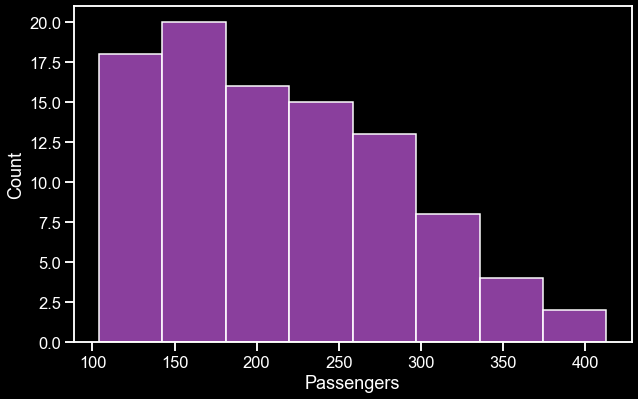

In [11]:
sns.histplot(data=viz, color='mediumorchid')
plt.show() #Passenger count with reference to months

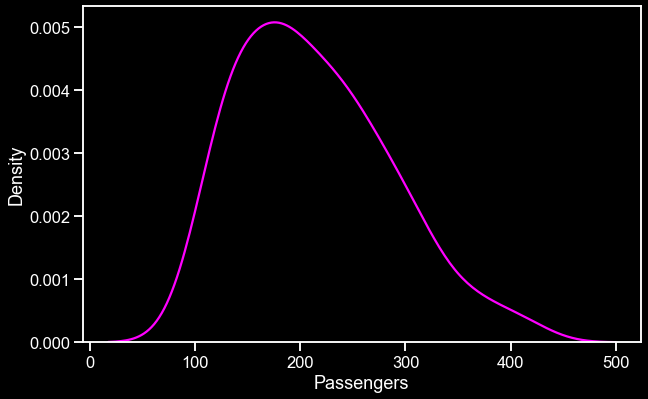

In [12]:
sns.kdeplot(data=viz, color='fuchsia')
plt.show() #Density Plot

In [13]:
data["month"] = data.Month.dt.strftime("%b") # month extraction
data["year"] = data.Month.dt.strftime("%Y") # year extraction

Text(0.5, 1.0, 'Heatmap of Passenger Count with Year and Months')

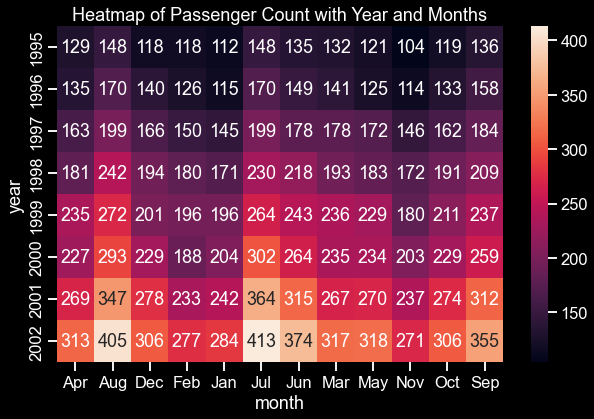

In [14]:
heatmap_y_month = pd.pivot_table(data=data,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")
plt.title('Heatmap of Passenger Count with Year and Months')

In [15]:
group=viz.groupby(pd.Grouper(freq='A'))
group.sum()

Month
1995-12-31    1520
1996-12-31    1676
1997-12-31    2042
1998-12-31    2364
1999-12-31    2700
2000-12-31    2867
2001-12-31    3408
2002-12-31    3939
Freq: A-DEC, Name: Passengers, dtype: int64

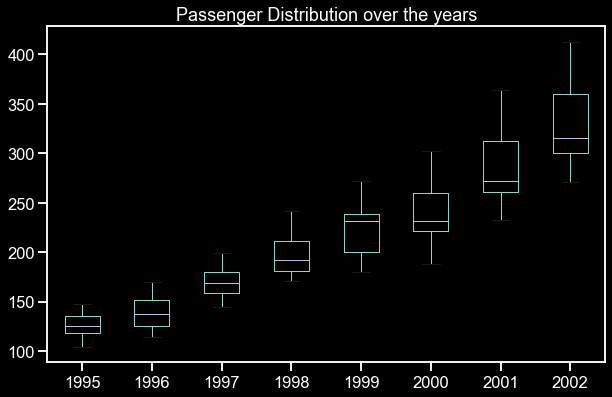

In [16]:
years=pd.DataFrame()
for i,j in group:
    years[i.year]=j.values
years.boxplot(grid=False)
plt.title('Passenger Distribution over the years')
plt.show()

##### Seasonal Decompose plots

In [17]:
decompose_ts = seasonal_decompose(viz,period=12)

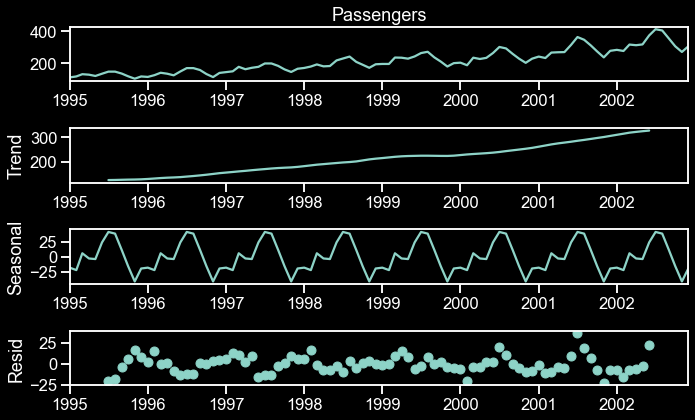

In [18]:
decompose_ts.plot()
plt.show() # plt show should be added otherwise 2 sets of graphs will be printed

##### ACF and PACF plots

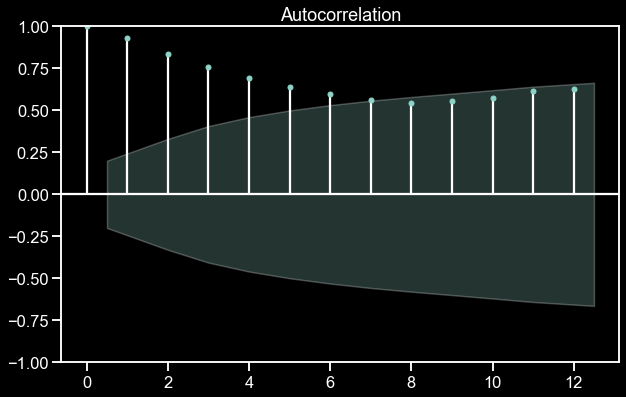

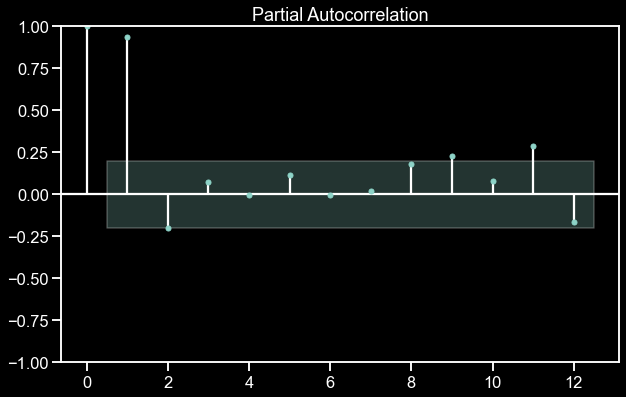

In [19]:
tsa_plots.plot_acf(viz,lags=12) 
#Autocorrelation Factor >> uptill 6 we have good corr() above +-2 SE [Standard Error]
tsa_plots.plot_pacf(viz,lags=12) 
#Partial Autocorrelation Factor >> only 9 and 11 show some good corr() +-2 SE [Standard Error]
plt.show()

## Preprocess data

#### Transformations

In [20]:
# adding t values >> new variable 1
data['t']= np.arange(1,data.shape[0]+1) 

In [21]:
# adding t_sqr values >> new variable 2
data['t_sqr'] = data['t']**2

In [22]:
# adding log_ values >> new variable 3
data['log_psgr'] = np.log(data['Passengers'])

In [23]:
#Generating dummies for months
month_dummies = pd.DataFrame(pd.get_dummies(data['month']))
data = pd.concat([data,month_dummies],axis = 1)

In [24]:
data.head()

,Month,Passengers,month,year,t,t_sqr,log_psgr,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,1995,1,1,4.718499,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,1995,2,4,4.770685,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,1995,3,9,4.882802,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1995,4,16,4.859812,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,1995,5,25,4.795791,0,0,0,0,0,0,0,0,1,0,0,0


#### Partition & Metrics

In [25]:
#Partition Series
train = data.iloc[:84]
test = data.iloc[84:]

##### RMSE for Predictive Accuracy
- Model with lowest RMSE is the best

In [26]:
#performance metrics 
pfm_model_bsd = dict() # For model driven
pfm_data_bsd = dict() # For Data driven

## Applying Forecasting Methods
### Model Driven

#### Classical ML Model based Methods

In [27]:
#Linear Model
linear_model = smf.ols('Passengers~t',data=train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
rmse_linear = mean_squared_error(test.Passengers, pred_linear, squared=False) #RMSE Calculation
pfm_model_bsd.update( {'Linear Model' : rmse_linear} )
rmse_linear

53.19923653480271

In [28]:
#Exponential
Exp = smf.ols('log_psgr~t',data=train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = mean_squared_error(test.Passengers, pred_Exp, squared=False)
pfm_model_bsd.update( {'Exponential Model' : rmse_Exp} )
rmse_Exp

325.71506135515364

In [29]:
#Quadratic 
Quad = smf.ols('Passengers~t+t_sqr',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_sqr"]]))
rmse_Quad = mean_squared_error(test.Passengers,pred_Quad, squared=False)
pfm_model_bsd.update( {'Quadratic Model' : rmse_Quad} )
rmse_Quad

48.05188897933164

In [30]:
#Additive seasonality 
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = mean_squared_error(test.Passengers,pred_add_sea, squared=False)
pfm_model_bsd.update( {'Additive seasonality' : rmse_add_sea} )
rmse_add_sea

132.81978481421817

In [31]:
#Additive Seasonality Quadratic 
add_sea_Quad = smf.ols('Passengers~t+t_sqr+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_sqr']]))
rmse_add_sea_quad = mean_squared_error(test.Passengers,pred_add_sea_quad, squared=False)
pfm_model_bsd.update( {'Additive Seasonality Quadratic' : rmse_add_sea_quad} )
rmse_add_sea_quad

26.36081761209504

In [32]:
#Multiplicative Seasonality
Mul_sea = smf.ols('log_psgr~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = mean_squared_error(test.Passengers,pred_Mult_sea, squared=False)
pfm_model_bsd.update( {'Multiplicative Seasonality' : rmse_Mult_sea} )
rmse_Mult_sea

326.2267987143024

In [33]:
#Multiplicative Additive Seasonality 
Mul_Add_sea = smf.ols('log_psgr~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = mean_squared_error(test.Passengers,pred_Mult_add_sea, squared=False)
pfm_model_bsd.update( {'Multiplicative Additive Seasonality ' : rmse_Mult_add_sea} )
rmse_Mult_add_sea 

325.6952488040335

In [34]:
result_model_bsd = pd.DataFrame(pfm_model_bsd.items(),columns=['MODEL', 'RMSE'])
result_model_bsd.sort_values(by=['RMSE'])
#Additive Seasonality Quadratic has the best values
# We will plot the forcasting in the evaluation part

,MODEL,RMSE
4,Additive Seasonality Quadratic,26.360818
2,Quadratic Model,48.051889
0,Linear Model,53.199237
3,Additive seasonality,132.819785
6,Multiplicative Additive Seasonality,325.695249
1,Exponential Model,325.715061
5,Multiplicative Seasonality,326.226799


###### Model Evaluation - Additive Seasonality Quadratic

In [35]:
data2 = data.copy()
data2.head()

,Month,Passengers,month,year,t,t_sqr,log_psgr,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,1995,1,1,4.718499,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,1995,2,4,4.770685,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,1995,3,9,4.882802,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1995,4,16,4.859812,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,1995,5,25,4.795791,0,0,0,0,0,0,0,0,1,0,0,0


In [36]:
data2.columns.values

array(['Month', 'Passengers', 'month', 'year', 't', 't_sqr', 'log_psgr',
       'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May',
       'Nov', 'Oct', 'Sep'], dtype=object)

In [37]:
data2.drop(['Month', 't_sqr', 'log_psgr',
       'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May',
       'Nov', 'Oct', 'Sep'], axis=1, inplace=True)
data2 = data2[['t', 'year', 'month', 'Passengers']] 
data1 = data2.copy()
data3 = data2.copy()
data_fnl = data2.copy()
data2.head()

,t,year,month,Passengers
0,1,1995,Jan,112
1,2,1995,Feb,118
2,3,1995,Mar,132
3,4,1995,Apr,129
4,5,1995,May,121


In [38]:
data2["Predicted"] = pd.Series(add_sea_Quad.predict(data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_sqr']]))
data2.head()

,t,year,month,Passengers,Predicted
0,1,1995,Jan,112,100.121972
1,2,1995,Feb,118,100.427467
2,3,1995,Mar,132,127.161533
3,4,1995,Apr,129,120.467028
4,5,1995,May,121,119.201095


In [39]:
# add a date column in the dataset
data2['Date'] = pd.date_range(start='1995-01-01', end = '2002-12-01', freq = 'MS')
data2.head()

,t,year,month,Passengers,Predicted,Date
0,1,1995,Jan,112,100.121972,1995-01-01
1,2,1995,Feb,118,100.427467,1995-02-01
2,3,1995,Mar,132,127.161533,1995-03-01
3,4,1995,Apr,129,120.467028,1995-04-01
4,5,1995,May,121,119.201095,1995-05-01


<AxesSubplot:xlabel='Date', ylabel='Value'>

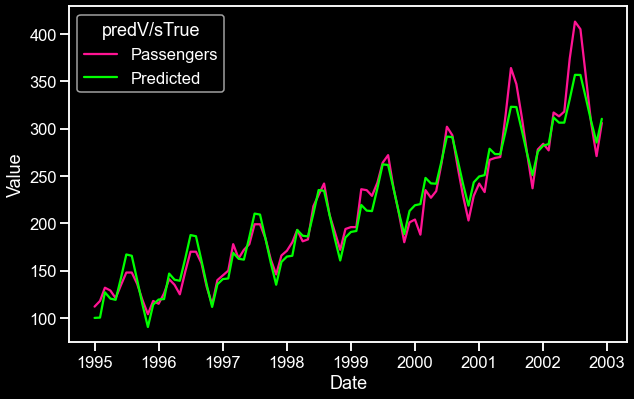

In [40]:
# line plot - View for the entire dataset _ ASQ
viz2 = data2.loc[:,["Date","Passengers","Predicted"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz2, x=viz2.Date, y=viz2.Value,hue="predV/sTrue",palette=["deeppink","lime"])
#There is large variance

<AxesSubplot:xlabel='Date', ylabel='Value'>

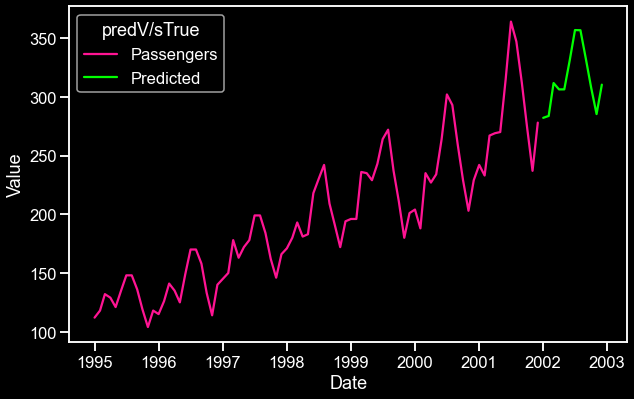

In [41]:
#Line plot - Train V/s Test Plot
data2.Predicted.iloc[:84] = np.nan
data2.Passengers.iloc[84:] = np.nan

viz3 = data2.loc[:,["Date","Passengers","Predicted"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz3, x=viz3.Date, y=viz3.Value,hue="predV/sTrue",palette=["deeppink","lime"])
#There is large variance from true value


#### Pycaret ML Model based Methods
- This is a low code library which is extremely good and fast
- https://towardsdatascience.com/time-series-forecasting-with-pycaret-regression-module-237b703a0c63

In [42]:
#we have copied this data from previous case
data1.head()

,t,year,month,Passengers
0,1,1995,Jan,112
1,2,1995,Feb,118
2,3,1995,Mar,132
3,4,1995,Apr,129
4,5,1995,May,121


In [43]:
#Partition Series
train1 = data1.iloc[:84]
test1 = data1.iloc[84:]

In [49]:
#Initialize setup

# import the regression module
from pycaret.regression import *
# initialize setup
s = setup(data = train1, test_data = test1, target = 'Passengers', 
          fold_strategy = 'timeseries', numeric_features = ['year', 't'], 
          fold = 3, transform_target = True, session_id = 123)

,Description,Value
0,Session id,123
1,Target,Passengers
2,Target type,Regression
3,Data shape,"(96, 4)"
4,Train data shape,"(84, 4)"
5,Test data shape,"(12, 4)"
6,Numeric features,2
7,Categorical features,2
8,Preprocess,True
9,Imputation type,simple


In [51]:
best = compare_models(sort = 'RMSE') #Super fast Library
#Best Values for Ridge Regression RMSE = 16.4864

Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [52]:
prediction_holdout = predict_model(best)

AttributeError: 'list' object has no attribute 'predict'

In [ ]:
# generate predictions on the original dataset
predictions = predict_model(best, data=data1)
predictions.head()

In [ ]:
# add a date column in the dataset
predictions['Date'] = pd.date_range(start='1995-01-01', end = '2002-12-01', freq = 'MS')
predictions.head()

In [ ]:
# line plot - View for the entire dataset

viz1 = predictions.loc[:,["Date","Passengers","Label"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz1, x=viz1.Date, y=viz1.Value,hue="predV/sTrue",palette=["aqua","red"])

In [ ]:
# line plot - View for Train vs test

predictions.Label.iloc[:84] = np.nan
predictions.Passengers.iloc[84:] = np.nan

viz4 = predictions.loc[:,["Date","Passengers","Label"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz4, x=viz4.Date, y=viz4.Value,hue="predV/sTrue",palette=["aqua","red"])
#Lesser Variance compared to previous cases

### Data Driven Forecasting Techniques

#### Moving Averages

In [ ]:
#Make seperate dataset
data_ma = raw_data.copy()
data_ma = data_ma.set_index('Month')

#Simple Moving Average SMA
data_ma['3-month-SMA'] = data_ma['Passengers'].rolling(window=3).mean()
data_ma['6-month-SMA'] = data_ma['Passengers'].rolling(window=6).mean()
data_ma['12-month-SMA'] = data_ma['Passengers'].rolling(window=12).mean()

data_ma.head()

In [ ]:
sns.lineplot(data=data_ma,palette=["deeppink","lime","w","aqua"]) #SMA Plot

In [ ]:
#for 3-Months only since it will have the lowest SMA
data_ma['3-month-SMA']=data_ma['3-month-SMA'].fillna(0)
rmse_SMA_3Months = mean_squared_error(data_ma.Passengers,data_ma['3-month-SMA'], squared=False)
pfm_data_bsd.update({'SMA-3Months':rmse_SMA_3Months}) 
rmse_SMA_3Months

In [ ]:
#Exponentially Weighted Moving Average EWMA
data_ma['EWMA3'] = data_ma['Passengers'].ewm(span=3,adjust=True).mean() #3month Span

#Line Plot EWMA
sns.lineplot(data=data_ma[["Passengers","EWMA3"]],palette=["deeppink","lime"]) #SMA Plot

In [ ]:
#for 3-Months only since it will have the lowest EWMA
data_ma['EWMA3'] =data_ma['EWMA3'] .fillna(0)
rmse_EWMA3 = mean_squared_error(data_ma.Passengers,data_ma['EWMA3'] , squared=False)
pfm_data_bsd.update({'EWMA 3Months':rmse_EWMA3}) 
rmse_EWMA3 

#### Smoothing Techniques

In [ ]:
#Simple Exponential Method
ses_model = SimpleExpSmoothing(train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
rmse_SES = mean_squared_error(test.Passengers,pred_ses, squared=False)
pfm_data_bsd.update({'SES':rmse_SES}) 
rmse_SES

In [ ]:
# Holt method 
hw_model = Holt(train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
rmse_Holt = mean_squared_error(test.Passengers,pred_hw, squared=False)
pfm_data_bsd.update({'Holt':rmse_Holt}) 
rmse_Holt

In [ ]:
#Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])
rmse_hwe_add = mean_squared_error(test.Passengers,pred_hwe_add_add, squared=False)
pfm_data_bsd.update({'HWE Add. Seas & Add. Trend':rmse_hwe_add}) 
rmse_hwe_add

In [ ]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
rmse_hwe_mul = mean_squared_error(test.Passengers,pred_hwe_mul_add, squared=False)
pfm_data_bsd.update({'HWE Mul. Seas & Add. Trend':rmse_hwe_mul}) 
rmse_hwe_mul                                              

In [ ]:
pfm_data_bsd

In [ ]:
result_data_bsd = pd.DataFrame(pfm_data_bsd.items(),columns=['MODEL', 'RMSE'])
result_data_bsd.sort_values(by=['RMSE'])
#Lowest RSME values are for HWE Multiplicative Seasonality and Additive Trend

###### Model Evaluation - HWE Multiplicative Seasonality and Additive Trend

In [ ]:
hwe_mul_model = hwe_model_mul_add.predict(start = data.index[0],end = data.index[-1])
data3['predicted'] = hwe_mul_model
data3.head()

In [ ]:
# add a date column in the dataset
data3['Date'] = pd.date_range(start='1995-01-01', end = '2002-12-01', freq = 'MS')
data3.head()

In [ ]:
# line plot - View for the entire dataset _ ASQ
viz5 = data3.loc[:,["Date","Passengers","predicted"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz5, x=viz5.Date, y=viz5.Value,hue="predV/sTrue",palette=["deeppink","lime"])
#Smallest Variance among all the models

In [ ]:
#Line plot - Train V/s Test Plot
data3.predicted.iloc[:84] = np.nan
data3.Passengers.iloc[84:] = np.nan

viz6 = data3.loc[:,["Date","Passengers","predicted"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz6, x=viz6.Date, y=viz6.Value,hue="predV/sTrue",palette=["deeppink","lime"])
#Best internal forecast so far


#### Auto Regression Models
- Our data has both trend and Seasonality. 
- Very less chance for it to be stationary data. 
- We will perform AD-Fuller test to determine stationarity.
- We will observe the ACF and PACF plots to determine suitable Lags.
- After that, we will perform LL test on each model to determine best values
##### AD-Fuller stationarity test

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [ ]:
data4=raw_data.copy()
data4=data4.set_index('Month')
data4.head()

In [ ]:
#AD- Fuller test
adf_test(data4) #As expected, data is non stationary
#We might need to use SARIMA test in this case

In [ ]:
#ACF and PACF Plots
tsa_plots.plot_acf(viz,lags=12) 
#Autocorrelation Factor >> uptill 6 we have good corr() above +-2 SE [Standard Error]
tsa_plots.plot_pacf(viz,lags=12) 
#Partial Autocorrelation Factor >> only 9 and 11 show some good corr() +-2 SE [Standard Error]
plt.show()

In [ ]:
# We will run a auto arima to determine the ARIME orders
!pip install pmdarima
from pmdarima import auto_arima # for determining ARIMA orders

In [ ]:
stepwise_fit = auto_arima(data4.Passengers, start_p=0, start_q=0,
                          max_p=12, max_q=12, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

In [ ]:
#Fitting a model
from statsmodels.tsa.arima_model import ARIMA

model_arima = ARIMA(train['Passengers'],order=(3,1,2))
results = model_arima.fit()
results.summary()

In [ ]:
pred_arima = results.predict(start=84, end=len(data4)-1, dynamic=False, typ='levels')

In [ ]:
#RMSE score of ARIMA
rmse_arima= mean_squared_error(test.Passengers,pred_arima, squared=False)
rmse_arima #This value is quite high and we will not use it for forecasting

## Evaluate and Compare Performance
- Best model we have got so far is the HWE Multiplicative Seasonality and Additive Trend
- We will build our final model based on this one

## Implementing Forecasting Model

In [ ]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
final_model = ExponentialSmoothing(data_fnl["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_final = final_model.predict(start = data.index[0],end = data.index[-1])

#Getting RMSE Score
rmse_final = mean_squared_error(data.Passengers,pred_final, squared=False)
rmse_final #This score is excellent

In [ ]:
data_fnl.head()

In [ ]:
data_fnl['final_pred']=pred_final
data_fnl.head()

In [ ]:
data_fnl['Date'] = pd.date_range(start='1995-01-01', end = '2002-12-01', freq = 'MS')
data_fnl.head()

In [ ]:
# line plot - View for the entire dataset FInal Model
viz8 = data_fnl.loc[:,["Date","Passengers","final_pred"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz8, x=viz8.Date, y=viz8.Value,hue="predV/sTrue",palette=["deeppink","lime"])
#Best model

In [ ]:
#Forecasting the future
future = pd.DataFrame(final_model.forecast(24)).reset_index()
future.rename(columns={'index':'t',0:'Forecast'},inplace=True)
future.head()

In [ ]:
#Creating Forecast dataset
forecast_df= pd.concat([data_fnl,future], axis=0)
forecast_df.drop('Date',axis=1)
forecast_df['Date']=pd.date_range(start='1995-01-01', end = '2004-12-01', freq = 'MS')
forecast_df.info()

In [ ]:
#Future Forecast

viz9 = forecast_df.loc[:,["Date","Passengers","Forecast"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz9, x=viz9.Date, y=viz9.Value,hue="predV/sTrue",palette=["deeppink","lime"])
#Best internal forecast so far

## Conclusion
- We have explored all the possible forecasting techniques.
- We have built our final model from HWE Multiplicative Seasonality and Additive Trend
- Forecasting for two years has been plotted.